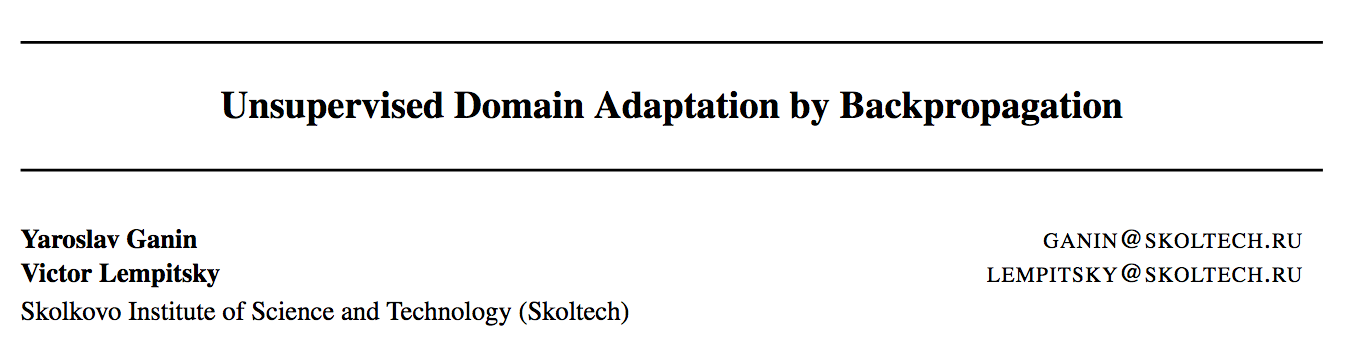

<center>Team 37-UNO<br></center>
Krati agrawal - 2022201063<br>
Anuja gulhane - 2022201070<br>
Hrishikesh Deshpande - 2022201065


Implementation of the paper **Unsupervised Domain Adaptation by Backpropagation** 
https://arxiv.org/abs/1409.7495

In [1]:
%matplotlib inline

<h1>Importing Libraries</h1>

In [1]:
import pickle
import math
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:
This script will help to generate the MNISTM dataset using MNIST data and BSDS500 patches

In [2]:
from mnistm import create_mnistm

create_mnistm()

Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [4]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


<h1><b>Dataset and Dataloaders</b></h1>

Create the loaders for MNIST...

In [5]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

In [6]:
len(mnist_train)
len(mnist_test)

10000

In [7]:
dataiter = iter(source_train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([128, 3, 28, 28])


... and visualize!

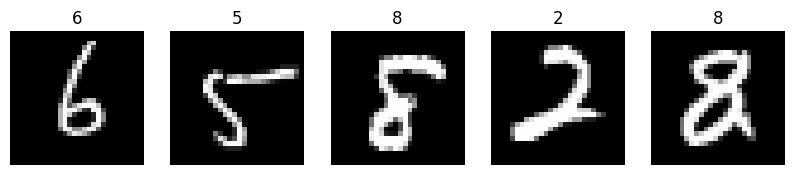

In [8]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle generated through patches in background with mnist.py script:

In [9]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_train,mnistm_val=torch.utils.data.random_split(mnistm_train, [50000, 10000])
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

In [10]:
len(mnistm_train)

50000

Visualize it. Observation says that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Notice that **MNIST-M** is extremely similar to MNIST. Because MNIST is in grayscale, we have concatenated thrice its channels axis.The only difference is that the former has colors and textures, and is thus a RGB image. 

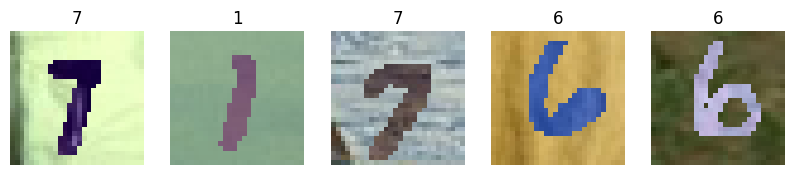

In [11]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

In [12]:
dataiter = iter(target_train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([128, 3, 28, 28])


This is the architecture follwed as given in the paper for MNIST

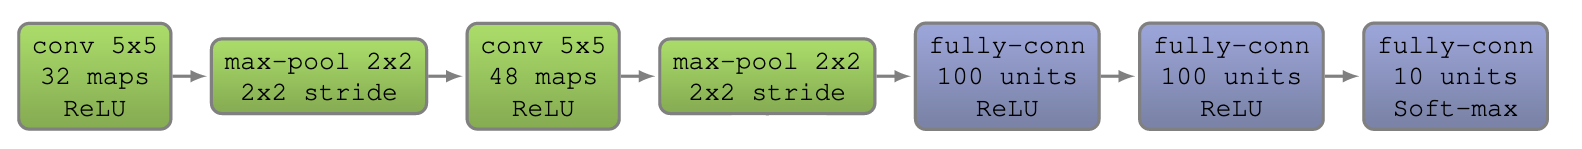

In [15]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5),  # 32x24x24
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 32x12x12
        nn.Conv2d(32, 48, kernel_size=5),  # 48x8x8
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 48x4x4
    )

    self.classif = nn.Sequential(
        nn.Linear(4 * 4 * 48, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)
    return self.classif(x)


# NaiveNet()(torch.randn(2, 3, 28, 28)).shape

In [16]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification. 

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [18]:
epochs = 20

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.43363
	Learning rate = 0.007377879464668811
Epoch 1, train loss: 0.06837
	Learning rate = 0.005946035575013606
Epoch 2, train loss: 0.0461
	Learning rate = 0.005029733718731742
Epoch 3, train loss: 0.03545
	Learning rate = 0.004386913376508308
Epoch 4, train loss: 0.02901
	Learning rate = 0.003907949713906801
Epoch 5, train loss: 0.02484
	Learning rate = 0.0035355339059327372
Epoch 6, train loss: 0.02184
	Learning rate = 0.0032366118113821563
Epoch 7, train loss: 0.01936
	Learning rate = 0.002990697562442441
Epoch 8, train loss: 0.01728
	Learning rate = 0.00278437664873526
Epoch 9, train loss: 0.01547
	Learning rate = 0.0026084743001221454
Epoch 10, train loss: 0.01389
	Learning rate = 0.0024564898981344154
Epoch 11, train loss: 0.01251
	Learning rate = 0.002323680802425408
Epoch 12, train loss: 0.01137
	Learning rate = 0.0022065006130979154
Epoch 13, train loss: 0.01039
	Learning rate = 0.0021022410381342864
Epoch 14, train loss: 0.0095
	Learning rate = 0.002008

Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Need to check how our model generalize on the slightly different domain of MNIST-M?

In [19]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.29085, test acc: 57.1


Having an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? To make the features as agnostic as possible from the domain: The gradient of the domain classifier should help to better classify the domain,if we reverse it before the end of the features extractor, we will force this CNN to do the opposite. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.
The below architecture with domain and label classifier is shown:

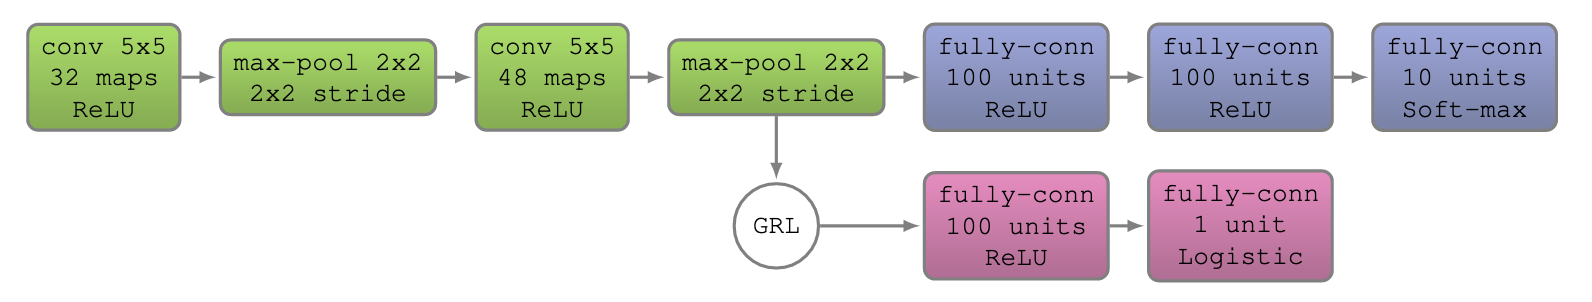

<H1>Gradient reversal Layer</h1>
To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [20]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    return factor * grad, None


In [21]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply 

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.
Whole Model is defined in three parts:
1. Feature Extractor (sequential pipeline for CNN)
2. Label Classifier  (without gradient reversal output of CNN)
3. Domain classifier (with reversing gradient before domain layer)

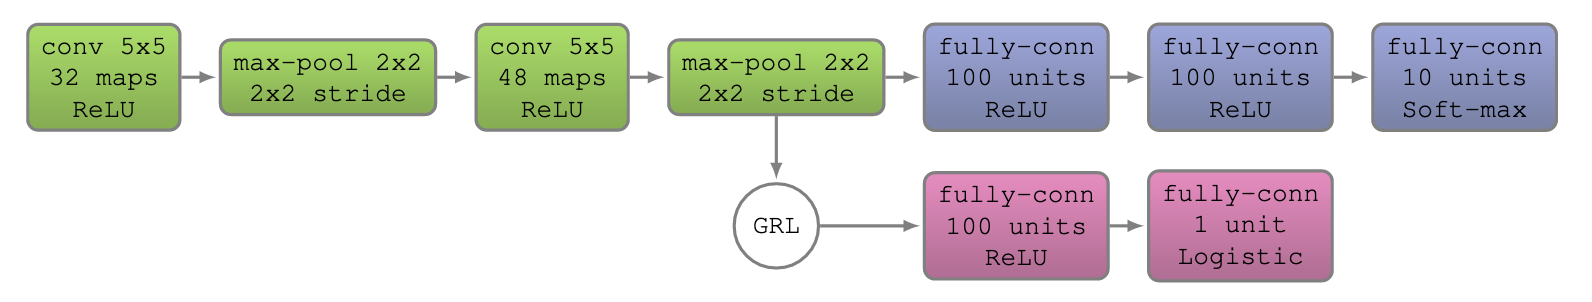

In [22]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5),  # 32x28x28
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 32x14x14
        nn.Conv2d(32, 48, kernel_size=5),  # 48x14x14
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 48x7x7
    )

    self.classif = nn.Sequential(
        nn.Linear(4 * 4 * 48, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10)
    )

    self.domain = nn.Sequential(
        nn.Linear(4 * 4 * 48, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 1)
    )

    self.grl = GradientReversal.apply

  def forward(self, x, factor=1):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)

    class_pred = self.classif(x)
    domain_pred = self.domain(self.grl(x, -1 * factor))

    return class_pred, domain_pred


In [25]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((domain_logits[:, 0] > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [34]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(782, 782)

<h1>GRL Plot:</h1>
For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

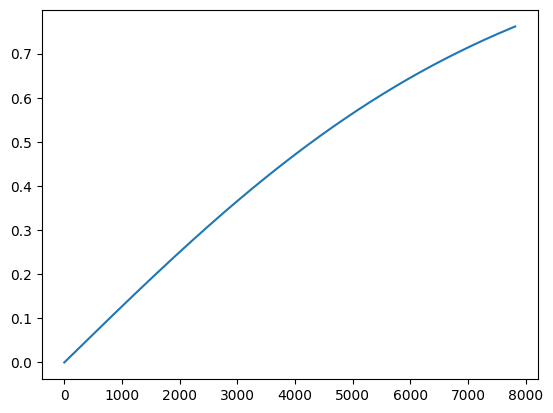

In [26]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

In [36]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))
    dann.zero_grad()
    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = F.cross_entropy(cls_logits[:len(ys)], ys)

    bce = F.binary_cross_entropy_with_logits(
        domain_logits[:, 0],
        torch.cat((
            torch.ones(len(xs)),
            torch.zeros(len(xt))
        )).cuda()
    )
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / len(source_train_loader), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 0.27898, domain loss: 0.23117
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.05361, domain loss: 0.19091
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.03662, domain loss: 0.20544
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.02791, domain loss: 0.22478
GRL factor 0.197375320224904
Epoch 4, class loss: 0.02603, domain loss: 0.26818
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.03014, domain loss: 0.308
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.04233, domain loss: 0.36249
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.04713, domain loss: 0.40497
GRL factor 0.379948962255225
Epoch 8, class loss: 0.05167, domain loss: 0.44539
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.06788, domain loss: 0.54856
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.06485, domain loss: 0.60657
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.05253, domain loss: 0.54208
GRL factor 0.5370495669980351
Epoch 12, cl

time recorded for 20 epochs:12m 11s

We should see a huge gain, from the 57% of accuracy on MNIST-M to 76% of accuracy without ever seeing labels of MNIST-M.

Hurrah!!!

## Target Only Training


In [29]:
epochs = 20

naive_net_target = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net_target.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in target_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net_target(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(target_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr' ]}")

test_acc, test_loss = eval_model(naive_net_target, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 1.21207
	Learning rate = 0.007377879464668811
Epoch 1, train loss: 0.294
	Learning rate = 0.005946035575013606
Epoch 2, train loss: 0.21345
	Learning rate = 0.005029733718731742
Epoch 3, train loss: 0.17076
	Learning rate = 0.004386913376508308
Epoch 4, train loss: 0.14506
	Learning rate = 0.003907949713906801
Epoch 5, train loss: 0.12664
	Learning rate = 0.0035355339059327372
Epoch 6, train loss: 0.11171
	Learning rate = 0.0032366118113821563
Epoch 7, train loss: 0.10041
	Learning rate = 0.002990697562442441
Epoch 8, train loss: 0.09091
	Learning rate = 0.00278437664873526
Epoch 9, train loss: 0.08267
	Learning rate = 0.0026084743001221454
Epoch 10, train loss: 0.07538
	Learning rate = 0.0024564898981344154
Epoch 11, train loss: 0.06912
	Learning rate = 0.002323680802425408
Epoch 12, train loss: 0.06353
	Learning rate = 0.0022065006130979154
Epoch 13, train loss: 0.05843
	Learning rate = 0.0021022410381342864
Epoch 14, train loss: 0.0537
	Learning rate = 0.0020087

**Let's now verify visualy that our features space is domain invariant:**

In [39]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    # print(x.shape)
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

As to visualise feature adaptation We use **TSNE** to visualize the embeddings. since we cant have lot features together using tsne to visualise on space of 2.

Here, we are using only subset of features as it can be go very slow to visualise.

In [37]:
from sklearn.manifold import TSNE

Original embeddings of source / target (50000, 768) (50000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

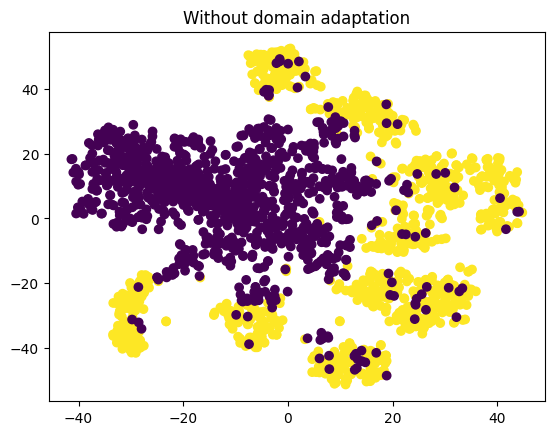

In [40]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (50000, 768) (50000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

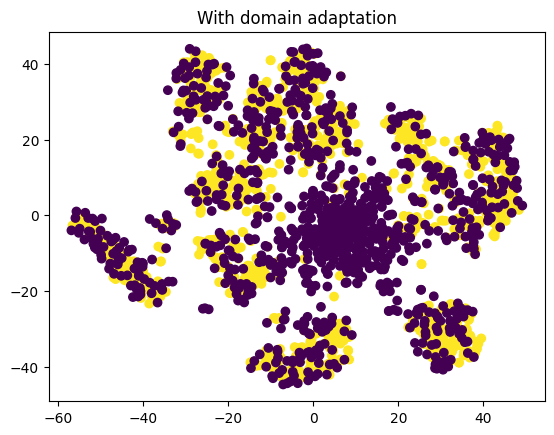

In [41]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN,the two domains are much more merged. This confirm our approach(paper) that the GRL forces the network to produce domain-invariant features.

Result and conclusion:
1. Source only: 57.1%
2. Domain adaptation: 76.8%
3. Target only: 95.55%

These results are aligned with paper results